In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tools import oneD_analysis
import numpy as np

In [2]:
initial_data = pd.read_csv("../Data/billets.csv", sep=";")

In [3]:
initial_data.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
initial_data["is_genuine"].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

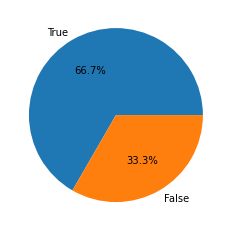

In [5]:
plt.pie(initial_data["is_genuine"].value_counts(normalize=True), labels=["True","False"], autopct='%1.1f%%')
plt.show()

In [6]:
initial_data.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

## Outlier's detection and correction

In [7]:
features = initial_data.columns[1:].values

In [8]:
features

array(['diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'], dtype=object)

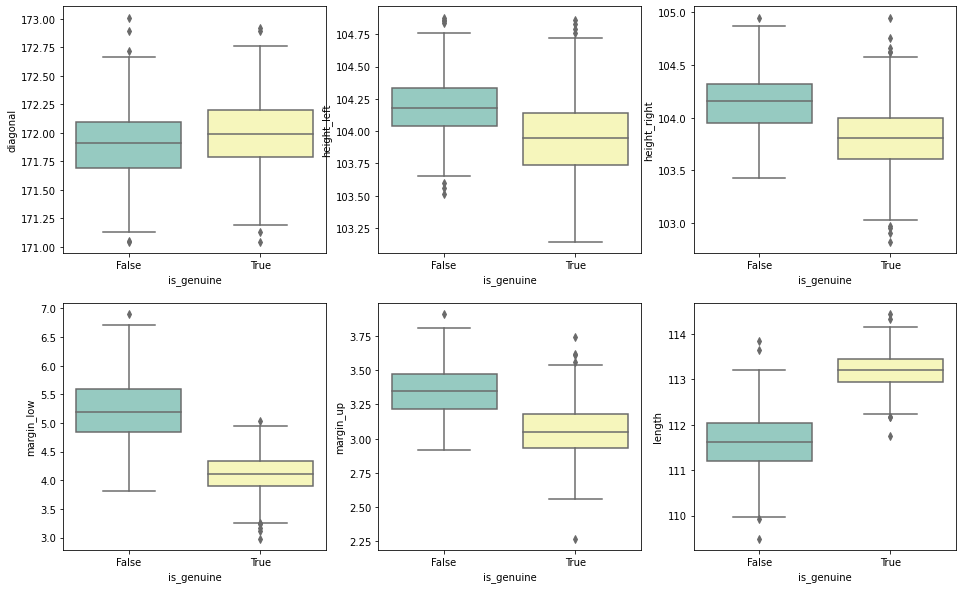

In [58]:
fig, ax = plt.subplots(2,3, figsize=(16,10))
box_indice = [(i,j) for i in range(0,2) for j in range(0,3)]
compteur = 0
for feature in features :
        row,column = box_indice[compteur]
        sns.boxplot(x="is_genuine", y=feature,
                     data=initial_data, palette="Set3", ax=ax[row,column])
        compteur+=1

**Note** : 
* La différence entre **un vrai** et **un faux** billet est marquée par **la marge inférieure/supérieure** et **la longueur horizontale** du billet  
* Très peu d'outliers éloignés des extrémités de l'ensemble de définition de nos variables  

**Action** : 
* Il est utile de garder les outliers des faux billets caractéristiques **d'une proportion non conforme**
* Nous supprimerons les outliers de la classe positive (billets authentiques) afin d'améliorer **la qualité des données** pour cette classe et ainsi améliorer **la prédiction finale** de notre modèle

In [ ]:
# Box plot pour chaque feature

In [10]:
initial_data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [79]:
# margin_low missing values display
initial_data.loc[initial_data["margin_low"].isna(),:].head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [82]:
from scipy import stats

In [83]:
# All values must be under z_score = 3 (0.5% of outliers called)
outliers_filter = (stats.zscore(initial_data[~initial_data["margin_low"].isna()][features]) < 3).all(axis=1) 
index = [i for i, val in enumerate(outliers_filter) if val]

# number of outliers

outliers_nb = len(outliers_filter) - outliers_filter.sum()
print("Outliers detected : {}".format(outliers_nb))

# outliers removing

outliersless = initial_data.loc[index]

Outliers detected : 16


In [85]:
# check Outliers 


# Features engineering

## Multiple Linear Regression with outliers (True class)

## Multiple Linear Regression with outliers (True and False classes mixed)

In [89]:
# Faire des tests pour valider les contraintes d'utilisation d'une RLM

In [74]:
# Replace missing values with multiple linear regression results

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


# parameters dict

parameters_ = {"test_size": 0.3,
              "data_set_size": 1500}

features = initial_data.columns[1:]
data_set = initial_data.loc[(~initial_data["margin_low"].isna()),
                            features][:parameters_["data_set_size"]]

# Get number of true observations 

nb_true_obs_ = len(initial_data)
nb_true_obs = data_set.shape[0]
print("True examples : {}".format(nb_true_obs))
print("Missing values rate : {}".format(1 - (nb_true_obs / nb_true_obs_)))

# setting X and Y vectors
features = list(features)
x_features = [feature for feature in features if feature!="margin_low"]
y_features = ["margin_low"]

X = data_set[x_features]
y = data_set[y_features]

# Splitting between train and test set

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=parameters_["test_size"], random_state=100)

# Fitting mlr with train set

mlr = LinearRegression()
mlr.fit(x_train, y_train)

# Parameters vectors
print("Intercept :")
print(*mlr.intercept_)
print("\n Coefficients : ")
print(list(zip(X,mlr.coef_.flatten())))

# Prediction on test set

y_pred = mlr.predict(x_test)
y_test["y_pred"] = y_pred
print(y_test)
# mlr evaluation

R_square = mlr.score(X,y)

meanAbErr = metrics.mean_absolute_error(y_test["margin_low"], y_pred)
meanSqErr = metrics.mean_squared_error(y_test["margin_low"], y_pred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test["margin_low"], y_pred))

print('R squared: {:.2f}'.format(mlr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

True examples : 1463
Missing values rate : 0.024666666666666615
Intercept :
28.136080581718474

 Coefficients : 
[('diagonal', -0.10186272346539829), ('height_left', 0.15916305172793174), ('height_right', 0.2377876907773883), ('margin_up', 0.23173527005070974), ('length', -0.427122489800819)]
      margin_low    y_pred
1476        5.13  5.228728
57          4.01  4.135039
411         3.74  4.085668
961         4.10  4.466255
650         3.78  4.250721
...          ...       ...
524         4.58  4.345420
1437        5.67  4.745447
407         4.45  3.987420
1387        5.39  5.104386
272         4.25  4.327206

[439 rows x 2 columns]
R squared: 47.68
Mean Absolute Error: 0.36674588801493613
Mean Square Error: 0.22806347286184822
Root Mean Square Error: 0.47755991546804705


## Multiple Linear Regression outliers free (True and False classes mixed)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


# parameters dict

parameters_ = {"test_size": 0.3,
              "data_set_size": 1500}

features = outliersless.columns[1:]
data_set = outliersless.loc[(~outliersless["margin_low"].isna()),
                            features][:parameters_["data_set_size"]]

# Get number of true observations 

nb_true_obs_ = len(outliersless)
nb_true_obs = data_set.shape[0]
print("True examples : {}".format(nb_true_obs))
print("Missing values rate : {}".format(1 - (nb_true_obs / nb_true_obs_)))

# setting X and Y vectors
features = list(features)
x_features = [feature for feature in features if feature!="margin_low"]
y_features = ["margin_low"]

X = data_set[x_features]
y = data_set[y_features]

# Splitting between train and test set

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=parameters_["test_size"], random_state=100)

# Fitting mlr with train set

mlr = LinearRegression()
mlr.fit(x_train, y_train)

# Parameters vectors
print("Intercept :")
print(*mlr.intercept_)
print("\n Coefficients : ")
print(list(zip(X,mlr.coef_.flatten())))

# Prediction on test set

y_pred = mlr.predict(x_test)
y_test["y_pred"] = y_pred
print(y_test)
# mlr evaluation

R_square = mlr.score(X,y)

meanAbErr = metrics.mean_absolute_error(y_test["margin_low"], y_pred)
meanSqErr = metrics.mean_squared_error(y_test["margin_low"], y_pred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test["margin_low"], y_pred))

print('R squared: {:.2f}'.format(mlr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

True examples : 1410
Missing values rate : 0.02557014512785072
Intercept :
24.708427166370456

 Coefficients : 
[('diagonal', -0.11200307516176831), ('height_left', 0.16598233025822262), ('height_right', 0.26453532916952505), ('margin_up', 0.27243521330452947), ('length', -0.41344413008884595)]
      margin_low    y_pred
356         4.14  4.026812
513         4.17  4.295759
544         4.52  4.005212
1267        5.47  4.514501
888         4.28  4.178911
...          ...       ...
1317        4.71  4.909720
150         4.08  4.243935
681         4.08  4.281633
658         3.90  4.097555
963         3.96  3.925724

[423 rows x 2 columns]
R squared: 47.88
Mean Absolute Error: 0.37206698354492673
Mean Square Error: 0.23128543091771298
Root Mean Square Error: 0.4809214394448567


## Which of these model Can I use for missing values replacement ?

In [86]:
# fill missing values with mlr margin low predictions

x_data = initial_data.loc[initial_data["margin_low"].isna(), x_features]
margin_low_predict = mlr.predict(x_data)

index = list(initial_data.loc[initial_data["margin_low"].isna(),:].index)
for index, value in zip(index, margin_low_predict):
    initial_data.loc[index,"margin_low"] = value

In [88]:
initial_data.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64